In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub 
import os
import ast

### Import Daraset

Downloaded the latest Spotify's Global Music datasest From Kaggle Website.

In [113]:
path = kagglehub.dataset_download("wardabilal/spotify-global-music-dataset-20092025")

print("Path to dataset files:", path)

os.listdir(path)

df = pd.read_csv(path + "/spotify_data clean.csv") 

Path to dataset files: C:\Users\Hp\.cache\kagglehub\datasets\wardabilal\spotify-global-music-dataset-20092025\versions\1


['spotify_data clean.csv', 'track_data_final.csv']

### Identify which track are popular

To identify which tracks can be considered popular, I first calculate the 80th percentile of the track_popularity scores. Tracks at or above this threshold are marked as popular in a new is_popular column. The value_counts() function shows the distribution of popular versus non-popular tracks.

From 8582 values I got 6754 songs thar are  not popular and 1828 songs that are popular.

In [145]:
track_threshold = df['track_popularity'].quantile(0.80)
df['is_popular'] = df['track_popularity'] >= track_threshold
df['is_popular'].value_counts()

is_popular
False    6754
True     1828
Name: count, dtype: int64

### Characaterstics of popular songs

In this cell, I analyze the characteristics of popular versus non-popular tracks. I group the data by the is_popular column and compute the mean for track duration, track number in the album, total tracks in the album, artist popularity, and artist followers. This helps show the typical profile of songs that reach the top 20 percent in popularity compared to those that don't.

In [121]:
df.groupby('is_popular')[['track_duration_min', 'track_number', 'album_total_tracks', 'artist_popularity', 'artist_followers']].mean()


,track_duration_min,track_number,album_total_tracks,artist_popularity,artist_followers
is_popular,,,,,
False,3.452279,5.954545,14.084987,66.801303,2.141123e+07
True,3.642538,5.100109,12.697484,80.550875,3.372785e+07


### Album type distribution

In this part of the analysis, I examine whether popular songs tend to come from specific album types. I group the data by is_popular and album_type to get their proportions, then create a stacked bar chart. This helps show how albums, singles, and compilations are distributed among popular and non-popular tracks.

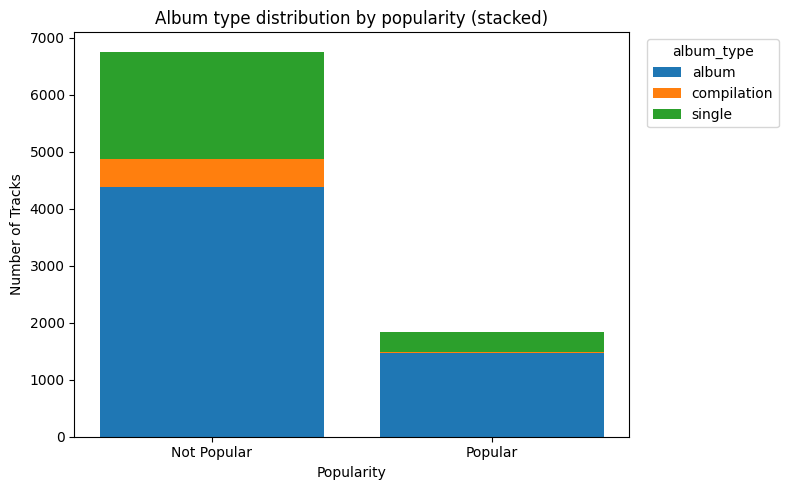

In [116]:

df.groupby('is_popular')['album_type'].value_counts(normalize=True)

# Stacked bar: album_type distribution split by is_popular
grouped = df.groupby(['is_popular', 'album_type']).size().unstack(fill_value=0)

# ensure order: Not Popular (False) then Popular (True) if present
order = [k for k in [False, True] if k in grouped.index]
grouped = grouped.reindex(order)

labels = ['Not Popular' if not v else 'Popular' for v in grouped.index]

fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(len(grouped))
for col in grouped.columns:
    vals = grouped[col].values
    ax.bar(labels, vals, bottom=bottom, label=col)
    bottom += vals

ax.set_xlabel('Popularity')
ax.set_ylabel('Number of Tracks')
ax.set_title('Album type distribution by popularity (stacked)')
ax.legend(title='album_type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


On the above chart we can see that from the popular songs, most them come from albums indicating albums tend to produce more popular songs.

### Explicit Content Analysis

In this section, we examine whether popular tracks are more likely to be explicit. 
We calculate the proportion of explicit and non-explicit tracks within the popular and non-popular groups. 
A stacked bar chart is then used to visualize the differences.


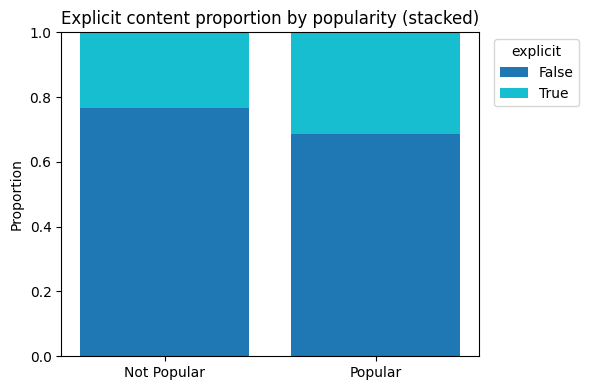

In [146]:
df.groupby('is_popular')['explicit'].value_counts(normalize=True)

# Stacked bar of the normalized explicit distribution split by popularity
cols = ['explicit']
if 'explicit' not in df.columns:
    raise KeyError("Missing column: 'explicit'")

# ensure is_popular exists
if 'is_popular' not in df.columns:
    if 'track_popularity' in df.columns:
        track_threshold = df['track_popularity'].dropna().quantile(0.80)
        df['is_popular'] = df['track_popularity'] >= track_threshold
    else:
        raise KeyError("Missing 'is_popular' and 'track_popularity'")

prop = df.groupby('is_popular')['explicit'].value_counts(normalize=True).unstack(fill_value=0)

# order rows as Not Popular (False) then Popular (True) if present
order = [k for k in [False, True] if k in prop.index]
prop = prop.reindex(order)

labels = ['Not Popular' if not v else 'Popular' for v in prop.index]

fig, ax = plt.subplots(figsize=(6,4))
bottom = np.zeros(len(prop))
colors = plt.cm.tab10(np.linspace(0, 1, prop.shape[1]))

for i, col in enumerate(prop.columns):
    vals = prop[col].values
    ax.bar(labels, vals, bottom=bottom, label=str(col), color=colors[i])
    bottom += vals

ax.set_ylabel('Proportion')
ax.set_title('Explicit content proportion by popularity (stacked)')
ax.set_ylim(0, 1)
ax.legend(title='explicit', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

The stacked bar chart shows that explicit tracks are slightly more common among popular songs. 
Non-popular tracks have a higher proportion of non-explicit songs. 
This suggests that explicit content may have a small association with track popularity, 
but the difference is not dramatic.


### Popularity Trend by Release Year

In this section, we examine how the popularity of tracks changes over time. 
We extract the release year from the album_release_date column and calculate the average popularity for each year. 
A line chart is then used to visualize trends in track popularity across years.


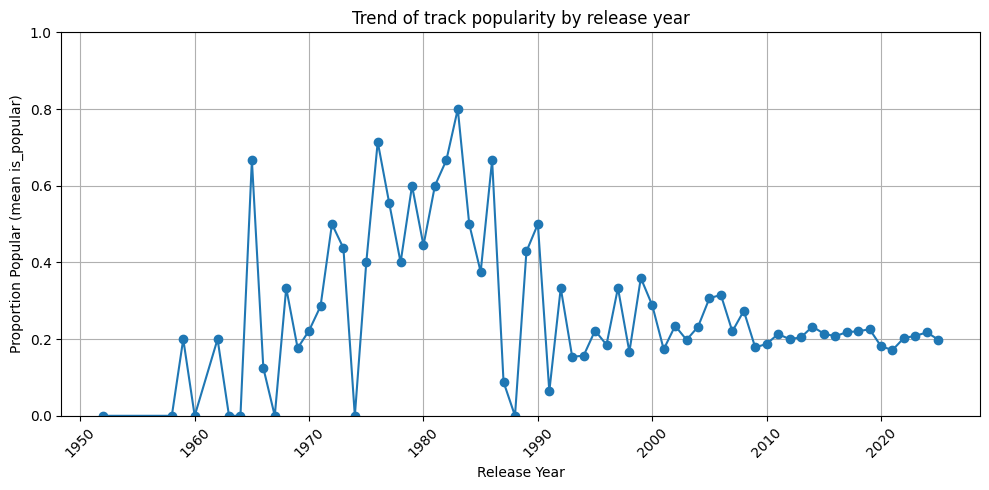

In [127]:
df['release_year'] = pd.to_datetime(df['album_release_date'], errors='coerce').dt.year
df.groupby('release_year')['is_popular'].mean()

# compute release year and plot popularity trend by year (line chart)
df['release_year'] = pd.to_datetime(df['album_release_date'], errors='coerce').dt.year

# ensure 'is_popular' exists
if 'is_popular' not in df.columns:
    if 'track_popularity' in df.columns:
        thresh = df['track_popularity'].dropna().quantile(0.80)
        df['is_popular'] = df['track_popularity'] >= thresh
    else:
        raise KeyError("Missing 'track_popularity' — cannot compute 'is_popular'")

pop_by_year = df.groupby('release_year')['is_popular'].mean().dropna().sort_index()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pop_by_year.index, pop_by_year.values, marker='o', linestyle='-')
ax.set_xlabel('Release Year')
ax.set_ylabel('Proportion Popular (mean is_popular)')
ax.set_title('Trend of track popularity by release year')
ax.set_ylim(0, 1)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Popularity by Main Genre

In this section, we analyze how track popularity varies across music genres. 
Since the dataset contains detailed sub-genres, we first list all unique genres and then map them into broader categories (pop, hip hop/rap, R&B/soul, rock, electronic, Latin, African, Asian, jazz/blues, classical, country/folk, and other). 

We assign each track a main genre based on the first listed genre for the artist and then calculate the average popularity rate for each main genre.


In [148]:
#List all unique genres in the dataset

all_genres = set()

for row in df['artist_genres'].dropna():
    genres = [g.strip().lower() for g in row.split(',')]
    all_genres.update(genres)

len(all_genres), list(all_genres)[:50]

# Function to map detailed genres to broader categories

def map_genre(g):
    if pd.isna(g):
        return "unknown"

    g = g.lower()

    # Pop family
    if "pop" in g: 
        return "pop"

    # Hip hop / rap / drill / trap rap
    if "hip hop" in g or "rap" in g or "drill" in g:
        return "hip hop / rap"

    # R&B / soul
    if "r&b" in g or "soul" in g:
        return "r&b / soul"

    # Rock
    if "rock" in g or "metal" in g or "punk" in g or "grunge" in g:
        return "rock"

    # Electronic family (EDM, house, techno, trance, phonk)
    if ("edm" in g or "house" in g or "techno" in g or "trance" in g 
        or "phonk" in g or "electronic" in g or "dubstep" in g):
        return "electronic"

    # Latin genres
    if "latin" in g or "reggaeton" in g or "salsa" in g or "bachata" in g:
        return "latin"

    # African genres (afrobeats, afro r&b, amapiano, nigerian drill)
    if ("afro" in g or "nigerian" in g or "amapiano" in g or 
        "alté" in g or "afrobeats" in g):
        return "african"

    # Asian genres (k-pop, c-pop, mandopop, j-pop)
    if "k-pop" in g or "korean" in g or "c-pop" in g or "mandopop" in g or "j-pop" in g:
        return "asian"

    # Jazz / blues
    if "jazz" in g or "blues" in g:
        return "jazz / blues"

    # Classical, orchestral, soundtrack
    if "classical" in g or "orchestra" in g or "soundtrack" in g or "opera" in g:
        return "classical"

    # Country / folk
    if "country" in g or "folk" in g or "americana" in g:
        return "country / folk"

    # If nothing matches
    return "other"

# Map main genre and analyze popularity by genre

df['main_genre'] = df['artist_genres'].dropna().apply(
    lambda x: map_genre(x.split(",")[0].strip())  # first genre is usually the primary
)
df['main_genre'].value_counts()
genre_popularity = df.groupby('main_genre')['is_popular'].mean().sort_values(ascending=False)
genre_popularity


main_genre
latin             0.540000
african           0.400000
pop               0.272727
hip hop / rap     0.263952
rock              0.245989
r&b / soul        0.184685
electronic        0.183871
jazz / blues      0.166667
country / folk    0.164228
other             0.155405
classical         0.002577
Name: is_popular, dtype: float64

The table shows the popularity rate for each main genre. Key observations:

- Latin and African genres have the highest proportion of popular tracks (54% and 40% respectively).  
- Pop and hip hop/rap tracks have moderate popularity rates (~27% and ~26%).  
- Rock and R&B/soul tracks have lower popularity rates (~25% and ~18%).  
- Electronic, jazz/blues, country/folk, and other genres have modest to low popularity rates.  
- Classical tracks are rarely popular (only ~0.3%).  

This indicates that genre is a meaningful factor in predicting track popularity. 
Latin and African tracks stand out as more likely to be popular among the dataset.


### Genre popularity using sorted vertical bar

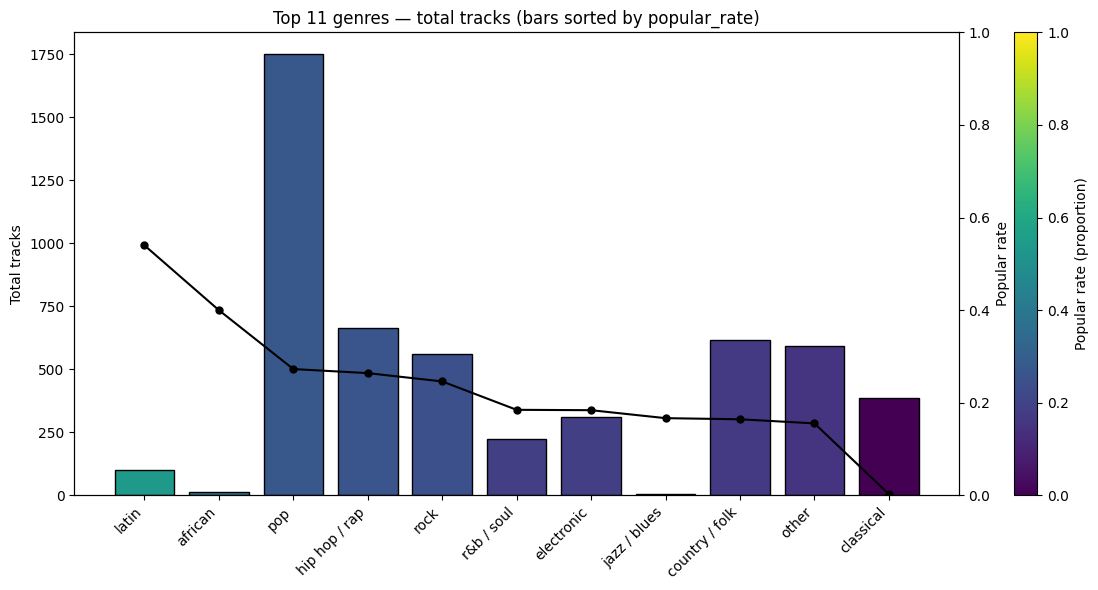

In [141]:
genre_summary = df.groupby('main_genre').agg(
    total_tracks = ('track_id','count'),
    popular_rate = ('is_popular','mean')
).sort_values('popular_rate', ascending=False)

genre_summary

# vertical bar sorted by popular_rate (or change sort_by to 'total_tracks')
sort_by = 'popular_rate'  # 'popular_rate' or 'total_tracks'
top_n = 30

# ensure main_genre exists
if 'main_genre' not in df.columns:
    if 'artist_genres' in df.columns:
        df['main_genre'] = df['artist_genres'].fillna('unknown').apply(lambda s: s.split(',')[0].strip().lower() if s else 'unknown')
    else:
        df['main_genre'] = 'unknown'

# ensure is_popular exists
if 'is_popular' not in df.columns:
    if 'track_popularity' in df.columns:
        thresh = df['track_popularity'].dropna().quantile(0.80)
        df['is_popular'] = df['track_popularity'] >= thresh
    else:
        raise KeyError("Missing 'is_popular' and 'track_popularity' — cannot compute popularity")

genre_summary = df.groupby('main_genre').agg(
    total_tracks = ('track_id','count'),
    popular_rate = ('is_popular','mean')
).dropna()

# pick top genres (by total_tracks) then sort by chosen metric for plotting
top = genre_summary.sort_values('total_tracks', ascending=False).head(top_n)
top = top.sort_values(sort_by, ascending=False)

import matplotlib as mpl
cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
colors = cmap(norm(top['popular_rate'].values))

fig, ax = plt.subplots(figsize=(12, max(6, 0.25*len(top))))
x = np.arange(len(top))

bars = ax.bar(x, top['total_tracks'], color=colors, edgecolor='k')
ax.set_xticks(x)
ax.set_xticklabels(top.index, rotation=45, ha='right')
ax.set_ylabel('Total tracks')
ax.set_title(f'Top {len(top)} genres — total tracks (bars sorted by {sort_by})')

# colorbar for popular_rate
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(top['popular_rate'].values)
fig.colorbar(sm, ax=ax, label='Popular rate (proportion)')

# overlay popular_rate as a line on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(x, top['popular_rate'].values, '-o', color='black', markersize=5)
ax2.set_ylabel('Popular rate')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()
